In [195]:
import numpy as np
from scipy.signal import butter, sosfilt, filtfilt
import matplotlib.pyplot as plt
import sounddevice as sd

In [196]:
# Load signal
samples = np.fromfile('./captures/baseband_1974900Hz_21-50-12_14-08-2025.wav', np.int16).astype(np.float32).view(np.complex64)
sample_rate = 2e6
center_freq = 1974.9e3
audio_fc = 1240e3
target_fs = 40e3

In [197]:
# Mix to audio center
offset = audio_fc - center_freq
t = np.arange(len(samples)) / sample_rate
mixer = np.exp(-1j * 2 * np.pi * offset * t)
mixed = samples * mixer

# Decimate to audio bw
decimation_factor = int(sample_rate // target_fs)
fs = sample_rate // decimation_factor
# Cutoff at (80% of) Nyquist rate after decimation
cutoff = (fs / 2) * 0.8

# Low-pass filter to prevent aliasing
sos = butter(6, cutoff, 'low', fs=sample_rate, output='sos')
filtered_samples = sosfilt(sos, mixed)

# Decimate
decimated_samples = filtered_samples[::decimation_factor]

# AM demod
envelope = np.abs(decimated_samples)
envelope_offset = envelope - np.mean(envelope)
audio = ((envelope_offset - np.min(envelope_offset)) / np.max(envelope_offset))

In [198]:
print(f"Original sample rate: {sample_rate/1e6:.1f} MHz")
print(f"Center freq: {center_freq/1e3:.1f} kHz") 
print(f"Audio freq: {audio_fc/1e3:.1f} kHz")
print(f"Offset: {offset/1e3:.1f} kHz")
print(f"New sample rate: {fs/1e3:.1f} kHz")
print(f"Decimation factor: {decimation_factor}")

Original sample rate: 2.0 MHz
Center freq: 1974.9 kHz
Audio freq: 1240.0 kHz
Offset: -734.9 kHz
New sample rate: 40.0 kHz
Decimation factor: 50


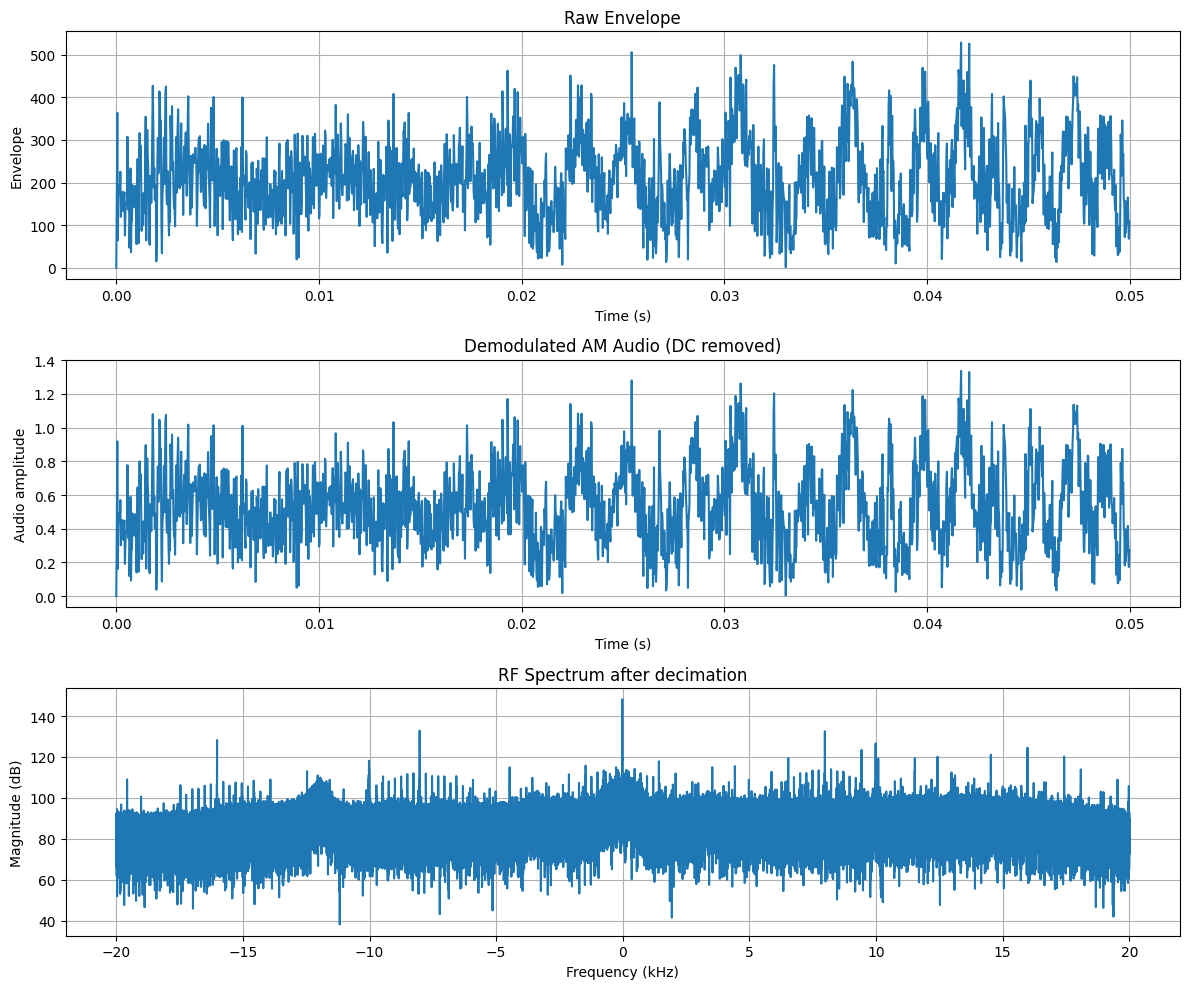

In [199]:
n_samples = int(0.05 * fs)
t = np.arange(n_samples) / fs

fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Plot 1: Raw envelope (short section)
n_samples = int(0.05 * fs)
t1 = np.arange(n_samples) / fs
axes[0].plot(t1, envelope[:n_samples])
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Envelope')
axes[0].set_title('Raw Envelope')
axes[0].grid(True)

# Plot 2: Normalized audio
axes[1].plot(t1, audio[:n_samples])
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Audio amplitude')
axes[1].set_title('Demodulated AM Audio (DC removed)')
axes[1].grid(True)

# Plot 3: RF Spectrum
freqs = np.fft.fftfreq(len(decimated_samples), 1/fs)
fft_mag = np.abs(np.fft.fft(decimated_samples))
axes[2].plot(freqs/1000, 20*np.log10(fft_mag + 1e-10))
axes[2].set_xlabel('Frequency (kHz)')
axes[2].set_ylabel('Magnitude (dB)')
axes[2].set_title('RF Spectrum after decimation')
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [200]:
# Raw audio
audio = envelope_offset / np.max(np.abs(audio))
sd.play(audio * 0.1, fs)

In [201]:
# Filter out high frequencies
b, a = butter(3, 3e3, 'lowpass', fs=fs)
audio_filtered = filtfilt(b, a, audio)
audio_norm = audio_filtered / np.max(np.abs(audio_filtered))
sd.play(audio_norm, fs)